In [9]:
from matplotlib import pyplot as plt
import numpy as np

## A small first step towards active inference: variational inference

You are sat in your London office and its time to go get lunch at the cafe down the road. You want to know whether it is raining so you can decide if you should bring your umbrella for the journey. From past experience you know in England it rains quite often, but you can't be sure. You need more information. You look to the window but sadly the office windows are frosted and you can only get a sense for how light it is outside. You reason that lower the light levels outside the more likely it is that is raining. You see its looking quite dark outside, so you take your umbrella.

Over in California another person in an identical situation sees low light levels out of the frosted window. They don't take their umbrella, it's probably just a bit cloudy.

During this process you are trying to reason about an unknown state of the world (is it raining). To do this you start with your prior knowledge of the world (what country you are in, the time of day, the time of year etc). You then make some new observation (outside light levels). 
You then combine your prior knowledge along with your beliefs about how the states of the world would produce your observations (raining outside would make it more likely for you to observe low light levels) to form a final belief of your confidence in the state. 

The process of combining prior beliefs with current observations to reason about states of the world is known as bayesian inference. In this post I aim to introduce some of the maths involved with bayesian inference using the simple example outlined above. I will then go on to describe Variational Inference, a common method for performing approximate bayesian inference. This is a small starting point for understanding a general theory for how animals reason about and act upon the world: Active Inference. 

## An example of bayesian inference

To make the qualitative description in the introduction more concrete lets define some notation to allow us to do bayesian inference.

- We have an agent which believes the outside environment can be in one of the 2 states, $s\in \{\text{rain}, \text{no rain}\}$. 
- Each of these states can cause one of 3 possible observation of the light levels, $o \in \{\text{low}, \text{med}, \text{high}\}$, 
- The agent has some prior beliefs about the probability of each state, $p(s)$.
- The agent has a model of how likely all observations are given a certain state: $p(o|s)$. We can represent this with a matrix $\bf{A}$, with entries $A_{ij} = p(o=i | s=j)$. You can view the columns of $\bf{A}$ as the likelihood of each state given an observation and rows as a probability distribution over observations given a state. In this case we have a matrix with 2 rows and 3 columns, mapping the 2 possible states to the 3 possible observations.

The agent can make an observation and then update its beliefs about the states using bayes rule.
Another way to say this is that the agents prior beliefs $p(s)$ are updated to form posterior beliefs $p(s|o)$ in response to some sensory information by the use of the agents model of likelihood attributed to observations of given states, $p(o|s)$. This can be written down as bayes rule:

$$ \underbrace{p(s|o)}_{\text{Posterior}} = \frac{\overbrace{p(o|s)}^{\text{Likelihood}}\overbrace{p(s)}^{\text{Prior}}}{\underbrace{p(o)}_{\text{Evidence}}} = \frac{p(o|s)p(s)}{\sum_{s}p(o|s)p(s)}$$ 


The following code defines a prior and likelihood matrix and for each possible observation plots the prior, likelihood, and posterior. 

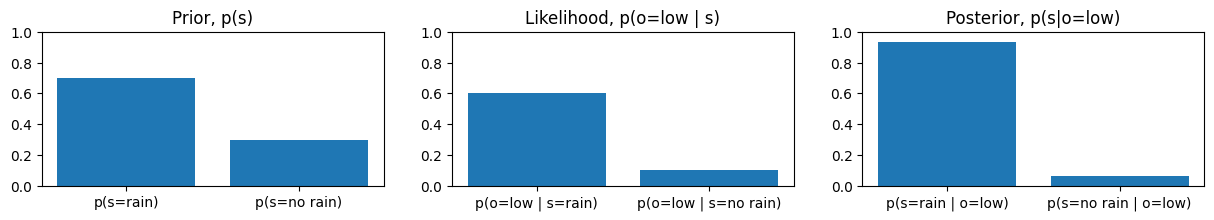

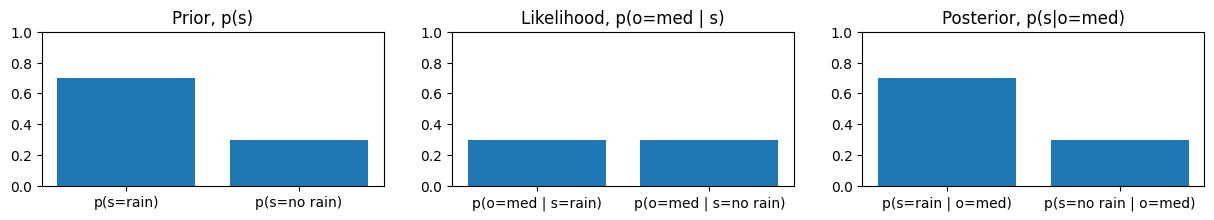

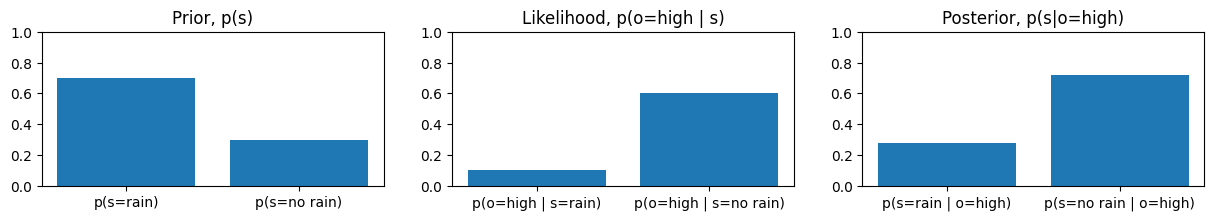

In [11]:
prior = np.array([0.7, 0.3]) # p(s=rain) = 0.7, p(s=no rain) = 0.3
A = np.array( # Likelihood mapping from states to observations
    [
        [0.6, 0.3, 0.1],  # Prob for observations o=low, o=med, o=high when in state s=rain
        [0.1, 0.3, 0.6],  # Prob for observations o=low, o=med, o=high when in state s=no rain
    ]
)

for i, observation in zip([0, 1, 2], ["low", "med", "high"]):
    likelihood = A[:, i] # p(o|s)
    evidence = sum(likelihood * prior) # p(o)
    posterior = likelihood * prior / evidence # p(s|o)

    # Plot prior, likelihood and posterior
    fig, axs = plt.subplots(1, 3, figsize=(15, 2))
    axs[0].bar(x=["p(s=rain)", "p(s=no rain)"], height=prior)
    axs[0].set_title("Prior, p(s)")

    axs[1].bar(x=[f"p(o={observation} | s=rain)", f"p(o={observation} | s=no rain)"], height=likelihood)
    axs[1].set_title(f"Likelihood, p(o={observation} | s)")

    axs[2].bar(x=[f"p(s=rain | o={observation})", f"p(s=no rain | o={observation})"], height=posterior)
    axs[2].set_title(f"Posterior, p(s|o={observation})")

    for ax in axs: 
        ax.set_ylim(0, 1)

When we observe low light levels, our model assigns high likelihood to rain. When combined with the prior which assigns a high probability to rain the posterior results in a very high probability for rain. In this case the observation 'agrees' with the prior beliefs which enforces and strengthens the beliefs.

When we observe medium light level our model assigns equal likelihood to rain and no rain. This means the observation is giving us no reason to change our prior beliefs so the posterior remains unchanged from the prior.

When we observe high light levels, our model assigns low likelihood to rain. When combined with the prior which assigns a high probability to rain the posterior results in higher probability for no rain. In this case the obervations 'disagrees' with the prior beliefs so pulls our prior beliefs in the opposite direction i.e to favour no rain.

Note that the posterior probability of no rain when observing high light levels is less than the posterior probability assigned to rain when observing low light levels. This is the result of the prior beliefs moderating the likelihood, when observations confirm our priors we become even more confident in our priors, when they contradict them we change our beliefs but we are less confident.

### Variational Inference 

In such simple example directly computing the posterior with bayes rule is the easiest way to update beliefs in response to observations. However in more realistic scenarios this is not possible. The problem is that the evidence term, which invovles summing over all possible states becomes computationally intractable when the state space becomes large.

$$p(o) = \sum_{s} p(o,s) = \sum_{s} p(o|s)p(s)$$


To get around this intractibilty there are numerous ways to approximate the true posterior but here we focus on variational inference due to it's use in Active Inference. 

In a sentence, variational inference finds an approximation of the true posterior by first creating a simple (but flexible) distribution and optimising the parameters of this distribution so it is as close as possible to the true posterior. This approach casts bayesian inference as an optimisation problem.

The simple distribution that we create we will call the variational distribution, $q(s)$. We now need to define a measure of distance between $q(s)$ and the true posterior $p(s|o)$. The Kullback–Leibler (KL) Divergence is used for this, it gives a strictly positive measure of the difference between probability distributions, with a value of 0 only if the two distributions are identical. The KL Divergance between the variational distribution and true posterior is defined as:

$$
D_{KL}[q(s)||p(s|o)] = \sum_{s} q(s) \ln\frac{q(s)}{p(s|o)}
$$

When $q(s)=p(s|o)$ this becomes $\sum_{s} q(s) \ln1 = 0$.

So now we just need to adjust the parameters of $q(s)$ so that this quantity is 0 (or close to 0). But how can we do this? The equation above contains the the true posterior and we don't know this, its exactly what we are trying to find. In this form we cannot minimise this function.

To get around this we need to do some algebra, starting with the definition above we get:

$$
\begin{split}
D_{KL}[q(s)||p(s|o)] &= \sum_{s} q(s) \ln\frac{q(s)}{p(s|o)} \\
                     &= \sum_{s} q(s) \ln\frac{q(s)p(o)}{p(s, o)} \\
                     &=\underbrace{\sum_{s} q(s) \ln\frac{q(s)}{p(o, s)}}_{\mathcal{F}} + \ln p(o)
\end{split}
$$

The first step uses bayes rule $p(s|o)=\frac{p(o,s)}{p(o)}$. The second step uses the identity of $\ln{ab}=\ln{a} + \ln {b}$ and the fact that $p(o)$ is independent of s and $\sum_{s}q(s) =1$ so $\sum_{s}{q(s) \ln p(o)} = \ln p(o)$.

The issue with minimising the KL term on the left directly is that we don't know the true posterior p(s|o) (if we did we would be done anyway!)

The final term is the model evidence, another term which is intractable. Again if we could compute the evidence we would be OK as we could simply use bayes rule directly to compute the posterior.

The 1st term on the right is known as the "variational free energy" $\mathcal{F}$ and is composed of terms that we actually have access to (the joint and variational distributions).

The free energy is commonly written in the following two equivalent forms:

$$
\begin{split}
\mathcal{F} &= \underbrace{D_{KL}[q(s)||p(s|o)]}_{\text{Divergence}} - \underbrace{\log p(o)}_{\text{Evidence}} \\
  &= \underbrace{D_{KL}[q(s)||p(s)]}_{\text{Complexity}} - \underbrace{\mathbb{E}_{q(s)}[\ln p(o | s)]}_{\text{Accuracy}}
\end{split}
$$

The first form is just the previous equation rearranged. It shows that if we can find a $q(s)$ which is exactly equal to the true posterior the divergence term becomes zero and the free energy becomes exactly equal to the evidence. This shows free energy as a lower bound on the model evidence, demonstrating why it is often called the Evidence Lower Bound or the ELBO in machine learning. 

Given that under some obervations the evidence term is fixed, lowering the value of $\mathcal{F}$ will necessarily be also lowering the divergence term. This means we can minimise $\mathcal{F}$ term as a proxy for minimising the KL divergence term. Finding the q(s) which minimises variational free energy is known as "Variational Inference".

The final form here shows that in minimising free energy we are looking for an approximate posterior which is minimally complex (similar to our prior beliefs about states s) while also being highly accurate (maximising the likelihood of our observations o).
This is a useful form as unlike the Divergence/Evidence form it is composed of terms we can compute (the prior, the likelihood and the variational posterior). This form is commonly used as the objective/loss function which is optimised to perform variational inference. For example this is exactly the loss function which is used to train variational autoencoders.

### Back to the example

To perform variational inference in our toy example we first need to choose a variational distribution, $q(s)$. Since we just have 2 states the easy choice is a Bernoulli distribution with a single parameter p, where $q(s=\text{rain}) = \text{p}$ and $q(s=\text{no rain}) = 1- \text{p}$. The task is now optimising the parameter of this distribution to minimise the variational free energy. 

In the code below we define a function to compute the free energy and plot the value of this function across the full parameter space of our variational distribution (p ranging from 0 to 1). In this case we can also directly compute the negative log evidence terms plot these.

Text(0.5, 1.0, 'Variational free energy as a function of approximate posterior parameter p')

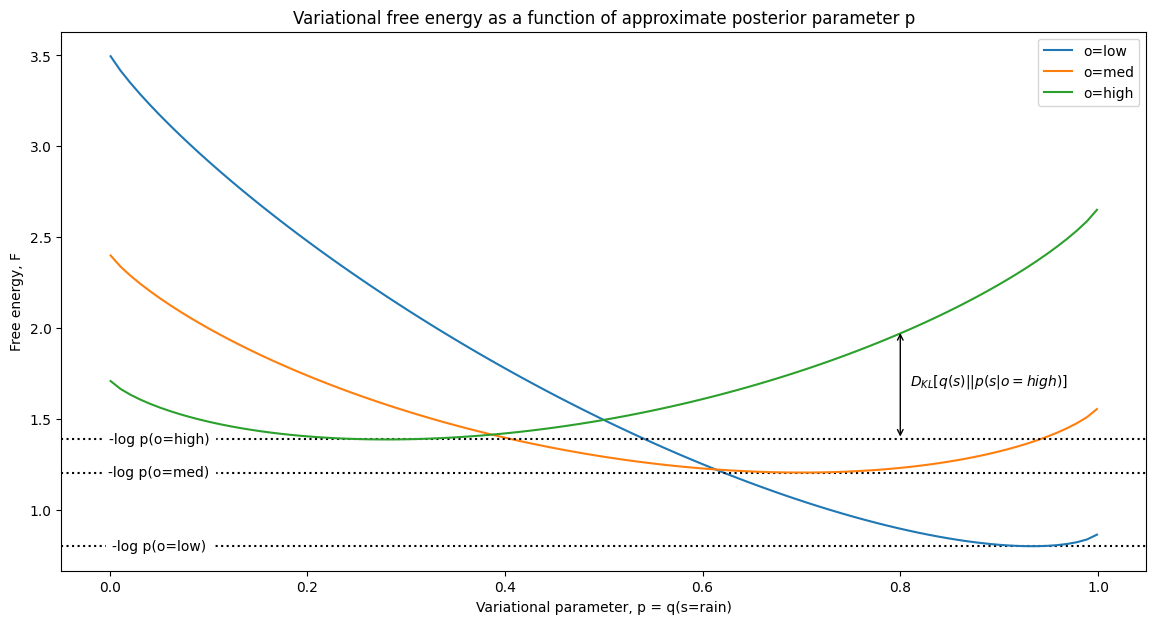

In [28]:

# Define how variational free energy is calculated from a given q_s
F = lambda q_s, likelihood, prior: sum(q_s * np.log(q_s / (likelihood * prior)))

# Compute F for arange of parameter p
es = {"o=low": [], "o=med": [], "o=high": []}
parameter_space = np.linspace(0.001, 0.999, 100)
for p in parameter_space:
    q_s = np.array([p, 1 - p])
    es["o=low"].append(F(q_s, A[:, 0], prior))
    es["o=med"].append(F(q_s, A[:, 1], prior))
    es["o=high"].append(F(q_s, A[:, 2], prior))

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# In this simple exmaple we can directly compute the evidence, useful to show on the plot
neg_log_evidence = lambda observation: -np.log(sum(A[:, observation] * prior))
for i, observation in zip([0, 1, 2], ["low", "med", "high"]):
    neg_le = neg_log_evidence(i)
    ax.axhline(neg_le, 0, 1, color="k", ls=":")
    ax.text(0.05, neg_le, f"-log p(o={observation})", fontsize=10, va='center', ha='center', backgroundcolor='w')
    ax.plot(parameter_space, es[f"o={observation}"], label=f"o={observation}")

# Annotate the KL divergence 
ax.annotate(text="", xy=(0.8, es[f"o=high"][80]), xytext=(0.8,neg_log_evidence(2)), arrowprops=dict(arrowstyle='<->'))
ax.annotate(text='$D_{KL}[q(s)||p(s|o=high)]}$', xy=(0.8, es[f"o=high"][80]), xytext=(0.81, neg_log_evidence(2) + 0.3))

ax.set_xlabel("Variational parameter, p = q(s=rain)")
ax.set_ylabel("Free energy, F")
ax.legend()
ax.set_title("Variational free energy as a function of approximate posterior parameter p")

There are 3 key observations to made from the above plot:

- The minimum of the free energy corresponds to a value of variational parameter, p, giving a distribution $q(s)$ exactly equal to the true posterior found from exact bayesian inference. You can read off the values of p which minimises $F$ for each observation and confirm that they correspond to the values of the true posterior $p(s|o)$ shown in plots in the previous section. Given we have a 1D parameter space we can simply plot and read off the minima, but in practice the optimisation can be done by performing gradient descent on the free energy. 

- When the free energy is minimised it becomes exactly equal to the negative log evidence. This is because we have managed to set the KL Divergence between the variational and true posterior to exactly 0, leaving only the evidence term in the definition of free energy. When the parameter p does not correspond to the exact posterior the KL divergence is the gap between negative log evidence and free energy, an example of this is marked on the plot. The fact we can make this divergence exactly 0 is due to the simplicity of the example. When things become more complex our choice of variational posterior may not be able to fully capture the shape of the true posterior so the free energy minima might be above the negative log evidence. 

- The negative log evidence has different values for different observations. 

## Variational inference in deep learning


### A Bayesian neural network 

We can view a neural network as a probabilistic model, which given an input $\bf{x}$ and a set of weights $\bf{w}$, will assign a probability to each possible output $\bf{y}$: $p(\bf{y}| \bf{x}, \bf{w})$. For a classification problem this is a categorical distribution over all the classes, corresponding to a cross-entropy or softmax loss. For regression $p(\bf{y}| \bf{x}, \bf{w})$ is a gaussian distribution, corresponding to a squared loss [7]. 

The weights of the network can be learnt by maximum likelihood estimation (MLE). Given a training dataset of inputs and labels  $\mathcal{D} = (\bf{x}_i, \bf{y}_i)_i$, MLE is performed by finding the value of $\bf{w}$ which maximises $p(\mathcal{D}|\bf{w})$:

$$
\begin{split}
\bf{w}^{MLE} &= \underset{\bf{w}}{\text{argmax}}\log \mathnormal{p}(\mathcal{D}|\bf{w}) \\
             &= \underset{\bf{w}}{\text{argmax}} \sum_{i} \log \mathnormal{p}(\bf{y}_i| \bf{x}_i, \bf{w})
\end{split}
$$

This is equivalent to just training a neural network with a standard mean squared or cross entropy loss. We can make things a bit more bayesian by finding the maximum of the posterior distribution (maximum a posteriori or MAP):

$$
\begin{split}
\bf{w}^{MAP} &= \underset{\bf{w}}{\text{argmax}}\log \mathnormal{p}(\mathcal{D}|\bf{w}) p(\bf{w}) \\
             &= \underset{\bf{w}}{\text{argmax}} \sum_{i} \log \mathnormal{p}(\bf{y}_i| \bf{x}_i, \bf{w}) + \log p(\bf{w})
\end{split}
$$

This is equivalent to  training a neural network with some regularisation term on the weights. 

However for a full bayesian treatment of this model we are not after just a point estimate of weights which maximise the likelihood or posterior. What we want is the full posterior distribution over the weights given the training data. In other words, starting from some prior beliefs about what the weights could be, we want to update these beliefs with the use of the likelihood to form posterior beliefs about the parameters. We can write this as Bayes rule:

$$
p(\bf{w}| \mathcal{D}) = \frac{\mathnormal{p}(\mathcal{D}|\bf{w})\mathnormal{p}(\bf{w})}{\mathnormal{p}(\mathcal{D})} = \frac{\mathnormal{p}(\mathcal{D}|\bf{w})\mathnormal{p}(\bf{w})}{\int_{\bf{w}}\mathnormal{p}(\mathcal{D}|\bf{w})\mathnormal{p}(\bf{w})\text{d}\bf{w}}
$$


The numerator of the fraction is easy for us to compute, we can choose a simple prior over the weights (for exmaple a gaussian with mean 0 and precision 1), and a likelihood function (gaussian for regression, categorical for classification). However, as ever the the evidence term requires an intractable integral over the entire weight space of the network, so we cannot find this normalising constant easily. One approach is then to use variational inference. We propose a distribution over the weights parameterised by $q_{\theta}(\bf{w})$ (the variational posterior), then the task becomes finding the $\theta$ which minimises the KL-divergence between $\theta$, $q_{\theta}(\bf{w})$ and the true posterior $p(\bf{w}| \mathcal{D})$. From the previous section we have shown that this is equivalent to minimising the variational free energy (or evidence lower bound, ELBO) so we can write down the optimal parameters as 

$$
\begin{split}
\theta^* &= \underset{\theta}{\text{argmin}} \space \mathcal{F} \\
         &= \underset{\theta}{\text{argmin}} \space \underbrace{D_{KL}[q_{\theta}(\bf{w})||\mathnormal{p}(\bf{w})]}_{\text{Complexity}} - \underbrace{\mathbb{E}_{q_{\theta}(\bf{w}))}[\ln p(\mathcal{D} | \bf{w})]}_{\text{Accuracy}}
\end{split}
$$

The variational free energy gives us a loss function to optimise to find the parameters of the posterior distribution. This optimisation can be achieved with backpropapgation, see the 'Bayes by Backprop' paper for more details on this [7].

How can predictions be made with this model? If we have the true posterior we can sample a set of weights from the posterior and then pass input samples through this network. However the more comprehensive way is making a model prediction for every possible combination of weights but each prediction is weighted by the posterior probability of the given weights for that prediction. Another way to say this is a prediction is the expectaion of the model predictions under the posterior distrubution over weights. Given we have a new sample $\hat{x}$ and we want to generate the predictive distribution of the unknown label $\hat{y}$ we can write this down as:

$$
\begin{split}
p(\hat{y} | \hat{x}, \mathcal{D}) &= \mathbb{E}_{\mathnormal{p}(\bf{w} | \mathcal{D})}[p(\hat{y} | \hat{x}, \bf{w}) ] \\
                            &=\int_{\bf{w}} p(\hat{y} | \hat{x}, \bf{w}) \mathnormal{p}(\bf{w} | \mathcal{D})\text{d}\bf{w} 
\end{split}
$$

This is known as the bayesian model average.


In practive we dont have access to the exact posterior and intergrating over the whole weight space is intractable. We can approximate the bayesian model average by taking N samples of weights from the learned variational posterior and making N model predictions, and avergaing them:
$$
p(\hat{y} | x, \mathcal{D}) \approx \frac{1}{N}\sum_{i=1}^{N} p(y | x, \bf{w}_i),   \bf{w}_i \sim q_{\theta}(\bf{w})
$$


### Variational inference using an autoencoder

In our intial example we had a generative model for observations (light levels through a window) which were produced from unobservable states of the world (rain or no rain outside). Inference of the model involved finding a distribution over the unobservable states given some observations. Here we present this model a bit more generally and give a tractable way to perform variational inference on it, the Variational Auto-Encoder (VAE) [8].

We have a dataset of N samples $\bf{x}_i$ of a random variable $\bf{x}$. We say that each $\bf{x}_i$ is generated by some process which depends on some latent random variable $\bf{z}$. First a value of $\bf{z}_i$ is drawn from some prior distribution over $\bf{z}$, $p(\bf{z})$, and then the observed data point is then sampled from the conditional distribution $p(\bf{x}|\bf{z})$. We can parameterize this generative model with parameters $\theta$ and write down the joint distribution over observed and latent variables:

$$
p_{\theta}(\bf{x}, \bf{z}) = \mathnormal{p}_{\theta}(\bf{x} | \bf{z})\mathnormal{p}_{\theta}(\bf{z})
$$

From this model we only have access to the observed data, the values of the corresponding latent variables $\bf{z}_i$ and the true model parameters $\theta$ are unobserved. Again we can write down bayes rules which will directly give us the posterior distribution over the latent variable

$$
p(\bf{z}| \bf{x}) = \frac{\mathnormal{p}_{\theta}(\bf{x} | \bf{z})\mathnormal{p}_{\theta}(\bf{z})}{\int_{\bf{z}}\mathnormal{p}_{\theta}(\bf{x} | \bf{z})\mathnormal{p}_{\theta}(\bf{z})\mathnormal{d}\bf{z}}
$$

As ever the evidence term requires an intractable integral (when the latent space is large) so we resort to variational inference. We propose a variational posterior over the latent space with parameters $\phi$, $q_{\phi}(\bf{z}|\bf{x})$.

This setup can be represented by the following graphical model, where the solid lines represent the generative model and the dashed show the vairational posterior. The box with the N in the corner is showing there are N of these variables (for each datapoint in the dataset), the parameters outside the box are fixed across the N datapoints. The circle with the grey background is indicating the variable is observed.

![img/vae.jpg](img/vae.jpg)


We would like to minimise the KL divergence between the variational posterior and the true intractable posterior. We have seen this can be achieved by minising the variational free energy which in this case is written as a funciton of the data and parameters of both the generative model and the variational posterior:

$$
\begin{split}
\mathcal{F(\theta, \phi; \bf{x})} &= \space \underbrace{D_{KL}[q_{\phi}(\bf{z}|\bf{x})||\mathnormal{p}_{\theta}(\bf{z})]}_{\text{Complexity}} - \underbrace{\mathbb{E}_{q_{\phi}(\bf{z}|\bf{x})}[\ln \mathnormal{p}_{\theta}(\bf{x} | \bf{z})]}_{\text{Reconstruction Error}}
\end{split}
$$

If we interpret the latent space as some form of encoding of our data, we can view the variational posterior as a probabilistic encoder which maps a data point $\bf{x}_i$ to a distribution of possible values for $\bf{z}$. Similarly we can view the likelihood $\mathnormal{p}_{\theta}(\bf{x} | \bf{z})$ as a probabilistic decoder mapping a latent value $\bf{z}_i$ to a distribtion over possible values of $\bf{x}$. With this in mind we can give and interpretation of the two terms which define $\mathcal{F}$:
 - Complexity: this ensures the variational posterior remains close to some prior distribution which we choose ($\mathcal{N}(0, 1)$ for example). This can be interpreted as a regularisation term, keeping the learnt distribution simple structured and continuous.
 - Reconstruction error: measures the similarity between the data point and the result of encoding and then decoding the datapoint. This is the standard loss function of an autoencoder.


Notice how in this section we have not yet mentioned neural networks. This is delibrate to emphasise that the model and thoery described is not tied to deep learning models. In fact in the original VAE paper [8] the use of a neural networks is just given as an example of the method of variational inference using an autoencoding scheme. 

To brielfly illustrate this exmaple, we can say that the variational posterior models a multivariate Gaussian with a diagonal covariance:
$$
\begin{split}
q_{\phi}(\bf{z}|\bf{x}) &= \mathcal{N}(\bf{z}, \bf{\mu}, \bf{\sigma}^2\bf{I}) \\

\vec{} = 
\end{split}
$$

where the mean and standard deviation are given my the output of a neural network, $g_{\phi}(\bf{x})$ with parameters $\phi$ (the 'encoder'). For contininuos data we can model the decoder as a Gaussian:

$$
\begin{split}
p_{\theta}(\bf{x}|\bf{z}) = \mathcal{N}(\bf{x}, \bf{\mu}, \bf{\sigma}\bf{I})
\end{split}
$$

### Active inference - Incorprating actions over time

We now include possible sequences of actions u, known as policies $\pi$

In [ ]:
# State transistion matrices parameterising p(s_t| s_t-1, pi)
B1 = np.array([
    [1, 0],
    [0, 1],
])
B2 = np.array([
    [0.5, 0.5],
    [0.5, 0.5],
])

# p(o|s) Likelihood mapping from states to observations. 
# Can view columns as likelihood of state give an observation 
# and rows as prob dist over observations given a state
A = np.array(
    [
        [0.1, 0.3, 0.6],
        [0.6, 0.3, 0.1],
    ]
)

# T=1
# Approx posterior
q_s_1 = np.array([0.7, 0.3])

# T=2 (the future)
# For a particular action B1

prior = B1 @ q_s_1 # q(s | pi) - new prior after state transition,
joint = A.T * prior # q(s, o| pi)
marginal = joint.sum(axis=1) # q(o|pi) - normally intractable

# p(s | o, pi)
posterior = joint / marginal[:, np.newaxis]

# evolutionary prior 
p_o = np.array([0.2, 0.8, 0.0])

future_joint = posterior.T * p_o

print(f"{prior = }")
print(f"{joint.T = }")
print(f"{marginal = }")
print(f"{posterior.T = }")
print(f"{future_joint = }")

: 

#### Expected free energy

While the goodness of model fit can be scored by the variational free energy $F$, the goodness of a policy can be scored by the expected free energy $G$. $G$ is different from $F$ in that the former requires planning i.e expectations about policy dependant future observations. 

Expected free energy $G$ at time step t, is the expectation of the difference between the approximate posterior over states and the joint distribution. A key difference here is that as we are projecting into the future the values of observations $o_t$ are unknown and so are random variables as opposed to fixed values from the present or past. This means the expection is made over an approximate joint distribution $q(s_t, o_t | \pi) = q(s_t | \pi)p(o_t | s_t)$.

$$
\begin{split}
G(\pi, t) &= \mathbb{E}_{q(s_t, o_t|\pi)}[\ln q(s_t|\pi) - \ln p(o_t, s_t|\pi) ] \\
 &= \sum_{s} q(s_t, o_t|\pi) \log \frac{q(s_t|\pi)}{p(s_t|o_t, \pi)p(o_t | \pi)} \\
 & = \sum_{s} q(s_t|\pi)\sum_{o}p(o_t|s_t) \log \frac{q(s_t|\pi)}{p(s_t|o_t, \pi)\underbrace{p(o_t | C)}_{\text{Evolutionary prior}}} \\
 & = ... = \\
 & =\underbrace{D_{KL}[q(o_t| \pi) || p(o_t | C)]}_{\text{Expected cost / Risk}} + \underbrace{\sum_{s} q(s_t|\pi) H[p(o_t | s_t)]}_{\text{Expected Ambiguity}}
\end{split}
$$

The evolutionary prior $p(o_t|C)$ replaces $p(o|\pi)$ as in active inference this quantity gives the value associated with observations which is independent of the policy chosen. The C-parameter can be thought of as encoding the agents prior preferences for e.g given the agent is a fish it would assign high prior preference to observe it's in water.

The final line shows the expected free energy as the sum of two terms:
- The difference between posterior predictive distribution and the preferred outcomes. 
- The uncertainty (entropy) over outcomes. This quantifies the ambiguity in the mapping between states and outcomes. For e.g the probability of a coin landing on heads conditioned on whether it is raining is maximally ambiguous as there is no connection between the two. 


Quote from the Active Inference book [1] "While numerical simulations have established that expected free energy is useful, the question of why it is useful is still and area of active research". See p250 of this book for a more detailed explanation and derivation. 


#### From free energy to action 

We get a distribution to sample policies from by taking the negative expected free energy under the policy and normalising it using a softmax to give a probability mass that sums to 1.

$$
G(\pi)  = \sum_{\tau} G(\pi, \tau) \\

p(\pi | \gamma) = \sigma(-\gamma \cdot G(\pi))
$$

Where $\tau \in\{t+1, t+2,..., T\}$, all future time steps given we are at time $t$. $\gamma$ is a precision parmeter which determines the confidence in beliefs about policies. High precision implies large probability on favoured policy (exploitation), low precision implies uniformly spread beliefs about policies (exploration). This distribution will assign high probability to policies with the lowest expected free energy.





## A generative model 

The (discrete time) generative model of active inference is a partially observable markov decision process.

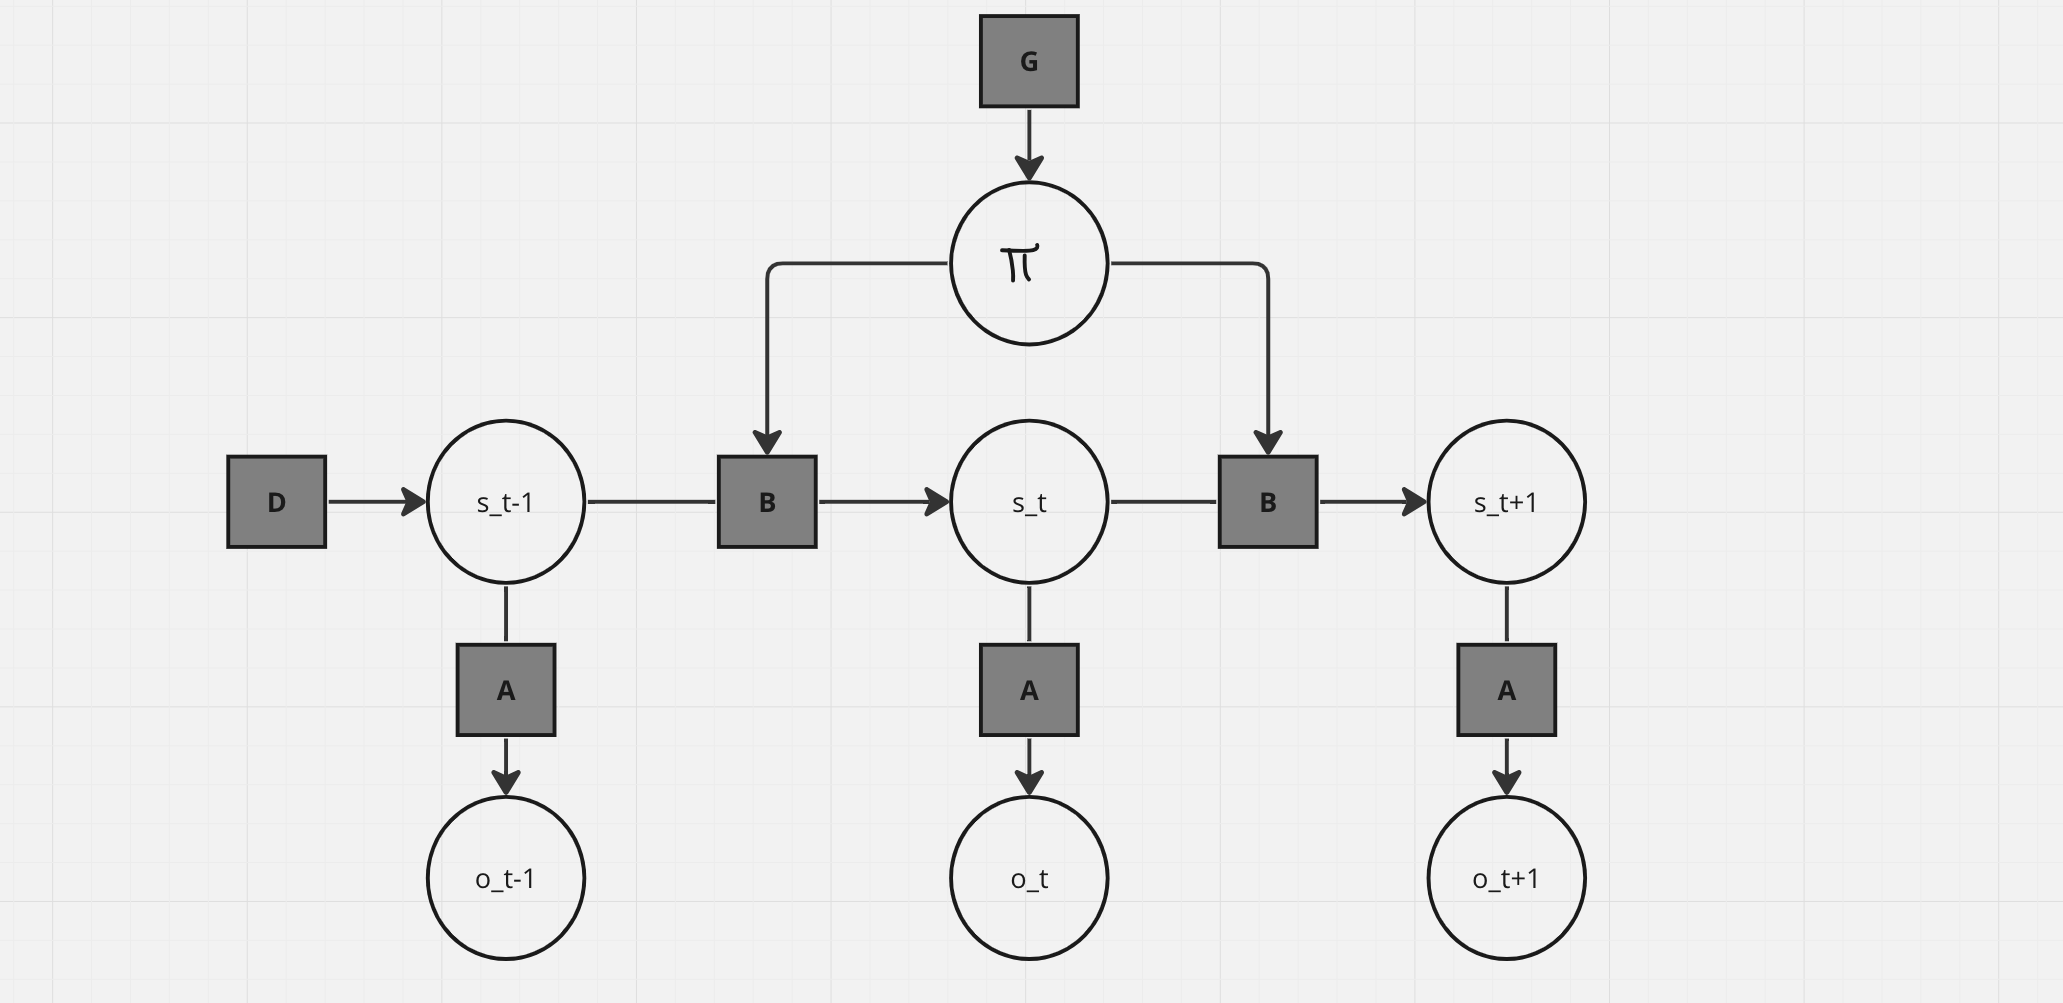

The model is defined  with the following quantities (largely following notation in [4]):

- Likelihood is a categroical distribution over observations given a hidden state

$$
P(o_t | s_t) = \text{Cat}(\bf{A})
$$
$$
A_{ij} = P(o_t = i | s_t = j)
$$

- State transistion. There is one state transition matrix $\bf{B}$ for each possible action. It encodes the probability of transition from one state to another under a certain action.

$$
P(s_{t+1} | s_t, \pi) = \text{Cat}(\bf{B}_{\pi t}) \\
$$

- Empirical priors over initial state and preference of observations

$$
P(s_1) = \text{Cat}(\bf{D})
$$
$$
P(o_t | C) = \text{Cat}(\bf{C_t})
$$


- Policies

$$
P(\pi | \gamma) = \sigma(-\gamma \cdot G(\pi))
$$
$$
G(\pi)  = \sum_{\tau} G(\pi, \tau)
$$
$$
G(\pi, \tau) = \mathbb{E}_{q(s_t, o_t, A|\pi)}[\ln Q(A) -\ln Q(A | s_t, o_t, \pi)] + D_{KL}[q(o_t| \pi) || p(o_t | C)] + \mathbb{E}_{q(s_t, o_t, A|\pi)} H[p(o_t | s_t)]
$$


- Parameters, these are the priors over the precision $\gamma$ and likelihood matrix $\bf{A}$

$$
P(\bf{A}) = Dir(a)
$$
$$
P(\gamma) = \Gamma(1, \beta)
$$


We can now write down the full joint distribution over a sequence of states, $\tilde{s}$, and observations, $\tilde{o}$, under policy $\pi$. Note we are assuming that an observation at a given time is dependant only on the state at the same time and at state at a given time is dependent only on the state prior to it and the action taken.

$$
P(\tilde{o}, \tilde{s}, \pi, \bf{A}, \gamma) = P(\pi | \gamma)P(\gamma)P(A) P(s_1)\prod_{t=2}^{T}P(o_t | s_t)P(s_t | s_{t-1}, \pi)
$$


### What actually happens during active inference

- 
- 


There are two types of updates that happen in an active inference agent:
- Inference - updates of beliefs about states.
- Learning - updates of beliefs about parameters (for e.g the precision $\gamma$ or dirichelet concentration $a$ from above)  


References:

[1] Active Inference Book: https://direct.mit.edu/books/oa-monograph/5299/Active-InferenceThe-Free-Energy-Principle-in-Mind

[2] Blog post: https://medium.com/@solopchuk/free-energy-action-value-and-curiosity-514097bccc02

[3] Blog post: https://medium.com/@solopchuk/tutorial-on-active-inference-30edcf50f5dc
    
[4] Computational mechanisms of curiosity and goal-directed exploration - https://www.biorxiv.org/content/biorxiv/early/2018/09/07/411272.full.pdf

[5] Discussion Paper - Active inference and epistemic value - https://www.fil.ion.ucl.ac.uk/~karl/Active%20inference%20and%20epistemic%20value.pdf

[6] Pymdp python package - https://pymdp-rtd.readthedocs.io/en/latest/notebooks/active_inference_from_scratch.html

[7] Weight Uncertainty in Neural Networks - https://arxiv.org/pdf/1505.05424

[8] Auto-Encoding Variational Bayes - https://arxiv.org/pdf/1312.6114